In [3]:
%load_ext autoreload
%autoreload 2

In [52]:
1

1

In [4]:
from hypergraph_generator import generate_hypergraph
from agent_country import run, run_parallel

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def run(H, beta = 0.2, q=0.4, endtime=10000, move='majority',log_freq=1000, seed=0):

    ### Egyszerű terjedés A=-1, B=1 vélemény fele-fele inicaializálással: ###

    #inicializáljuk 
    N=len(H.nodes) # csúcsok száma
    opinion=-1*np.ones(N) # vélemény vektor
    init_B=np.random.choice(H.nodes,int(N/2),replace=False) #random a fele B véleményre
    opinion[init_B] = np.ones(len(init_B))

    #list of logs
    sum_A_log=[np.sum(opinion == -1)]
    sum_B_log=[np.sum(opinion == 1)]
    
    binned_opinions_home = []
    binned_opinions_wp = []
    binned_opinions_wp_pop_sized = []
    binned_edge_sizes_wp=[]
    
    move_count = []
    op_change_count = []
    
    move_count_act=0
    op_change_count_act =0
    
    for i in range(endtime):
        
        act_node = np.random.choice(H.nodes,1)[0]
        try:
            diff_opinions = np.array([np.sum(opinion[edge]!=opinion[act_node]) for edge in H.edgelists[act_node]])

        except:
            print(act_node,H.edgelists[act_node])
            break

        edge_sizes = np.array([len(edge) for edge in H.edgelists])

        #terjedés : h, w a különböző véleményen lévők aránya a háztartás és munkahely élekben: 
        #változás valószínűsége: beta * (h + 0.5 m) / 1.5
        h = diff_opinions[0]/edge_sizes[0]
        m = diff_opinions[1]/edge_sizes[1]
        
        if (h + 0.5 * m)/1.5 > 0.5  and np.random.random() < beta * ((h + 0.5 * m)/1.5 - 0.5):
            opinion[act_node]=-1*opinion[act_node]
            op_change_count_act +=1

        elif m > 0.5 and np.random.random() < q * (m - 0.5):
            #print('edgelist',H.edgelists[act_node])
            sum_by_edge = np.array([np.sum(opinion[edge]==opinion[act_node]) for edge in H.edges])
            if move=='majority':
                 edge_to_move = np.random.choice(np.arange(int(number_of_edges/2))[sum_by_edge[int(number_of_edges/2):]>0.5],1)[0] + int(number_of_edges/2)
            elif move=='proportional':
                 edge_to_move = np.random.choice(np.arange(int(number_of_edges/2)),1,p=sum_by_edge[int(number_of_edges/2):]/np.sum(sum_by_edge[int(number_of_edges/2):]))[0] + int(number_of_edges/2)
            
           
            H.edgelists[act_node][1].remove(act_node)
            H.edgelists[act_node].remove(H.edgelists[act_node][1])
            H.edges[edge_to_move].append(act_node)
            H.edgelists[act_node].append(H.edges[edge_to_move])
            move_count_act+=1
            #print('act node',act_node)
            #print('edge_to_move', H.edges[edge_to_move])
            #print('edgelist',H.edgelists[act_node])
            #print('edges',H.edges)
        # distribution of workplace edge sizes
        
        
        if i%log_freq==0:
            sum_A_log.append(np.sum(opinion == -1))
            sum_B_log.append(np.sum(opinion == 1))

            # opinion sums
            opinion_sums_home=[np.sum(opinion[edge]==-1) for edge in H.edges[:int(number_of_edges/2)]]
            z=np.histogram(opinion_sums_home, bins=np.arange(7))
            binned_opinions_home.append(z[0])

            opinion_rates_wp=[np.sum(opinion[edge]==-1)/len(edge) for edge in H.edges[int(number_of_edges/2):]]
            z=np.histogram(opinion_rates_wp, bins=np.arange(11)/10)
            binned_opinions_wp.append(z[0])
            
            popsized=[]
            bins = np.arange(11)/10
            for i in range(10):
                popsized.append(0)
                for edge in H.edges[int(number_of_edges/2):]:
                    if bins[i]<=np.sum(opinion[edge]==-1)/len(edge)<bins[i+1]:
                        popsized[-1] += len(edge)
                    elif i==9 and np.sum(opinion[edge]==-1)/len(edge)==bins[i+1]:
                        popsized[-1] += len(edge)
            binned_opinions_wp_pop_sized.append(np.array(popsized))

            # workplace sizes
            edge_sizes_wp=[len(edge) for edge in H.edges[int(number_of_edges/2):]]
            z=np.histogram(edge_sizes_wp, bins=np.arange(15))
            binned_edge_sizes_wp.append(z[0])
            
            #move,  change count
            move_count.append(move_count_act)
            op_change_count.append(op_change_count_act)
            move_count_act = 0
            op_change_count_act = 0
        
    return sum_A_log,binned_opinions_home,binned_opinions_wp,binned_edge_sizes_wp, binned_opinions_wp_pop_sized, move_count,op_change_count, is_connected(H)

In [36]:
betas=np.arange(0.1,1,0.2)
qs=[0]
data = []
connected = []
for i in range(len(betas)):
    data.append([])
    connected.append([])
    for j in range(len(qs)):
        graph_args={'name': 'd_regular', 'args': {'n':1000, 'd':2,'edge size':5, 'distribution':'uniform'}}
        np.random.seed(0)
        H = generate_hypergraph(graph_args['name'], graph_args['args'])
        number_of_edges=len(H.edges)
        d = run(H, beta = betas[i], q = qs[j], endtime=50000, move='majority',log_freq=1000, seed=0)
        data[-1].append(d)
        

In [47]:
data[0][0][0]

[500,
 500,
 511,
 517,
 523,
 526,
 524,
 523,
 522,
 528,
 530,
 534,
 543,
 545,
 544,
 549,
 550,
 547,
 550,
 544,
 549,
 554,
 554,
 557,
 563,
 562,
 563,
 565,
 571,
 574,
 579,
 579,
 580,
 576,
 579,
 581,
 579,
 579,
 576,
 574,
 573,
 572,
 573,
 571,
 568,
 568,
 565,
 566,
 571,
 577,
 577]

In [22]:
def is_connected(H):
    
    V = list(set(H.edgelists[0][0] + H.edgelists[0][1]))
    seen = np.zeros(len(H.nodes))
    seen[V] = 1
    while V:
        z = V.pop()
        neighs = H.edgelists[z][0] + H.edgelists[z][1]
        for niegh in neighs:
            if seen[niegh] != 1:
                V.append(niegh)
                seen[niegh] = 1
                
    return np.sum(seen) == len(H.nodes)

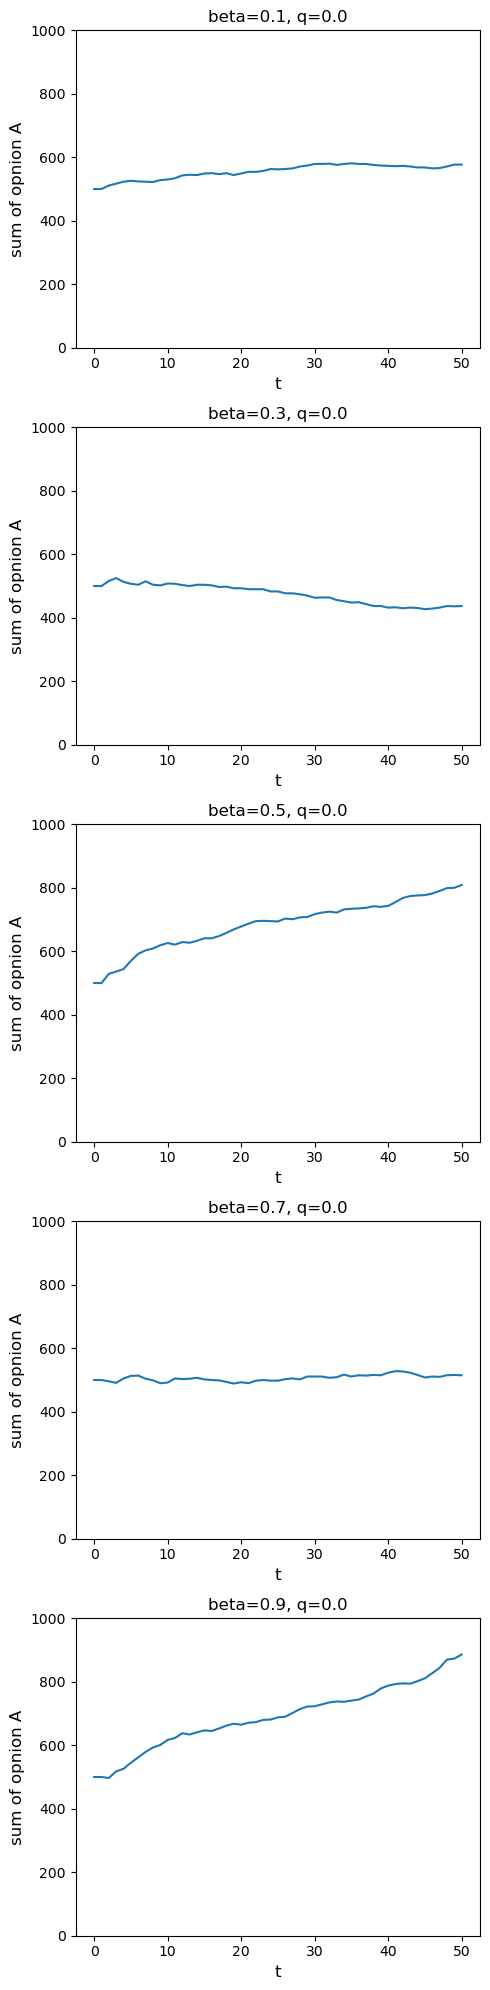

In [49]:
fs=12
ts=10
fig, axes = plt.subplots(len(betas),len(qs), figsize=(5,20))
axes=axes.flatten()
k=0
for i in range(0,len(betas)):
    for j in range(0,len(qs)):
        results=data[i][j]
        ax=axes[k]
        k+=1
        beta=betas[i]
        q=qs[j]
        
        ax.plot(results[0])
        ax.set_ylabel('sum of opnion A',fontsize=fs)
        ax.set_xlabel('t',fontsize=fs)
        ax.set_title(f'{beta=:.1f}, {q=:.1f}',fontsize=fs)
        ax.tick_params('both', labelsize=ts)
        ax.set_ylim((0,1000))
plt.tight_layout()
#plt.savefig('figures/sum_of_A_majority.pdf')
plt.show()

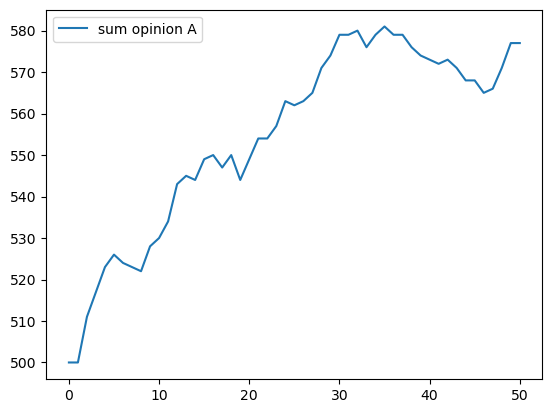

In [50]:
#egyszerű plot a vélemények összegéről
plt.figure()
plt.plot(data[0][0][0], label='sum opinion A')
plt.legend()
plt.show()

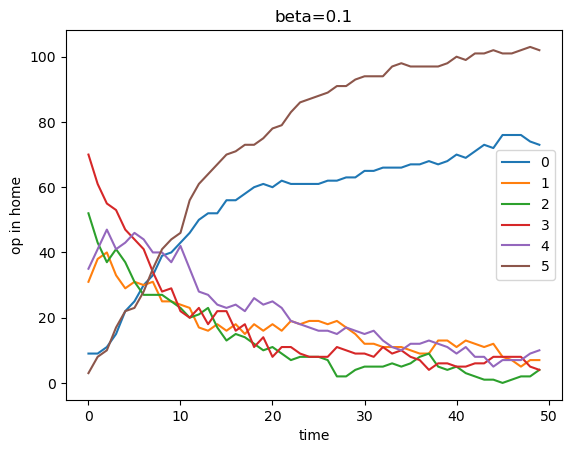

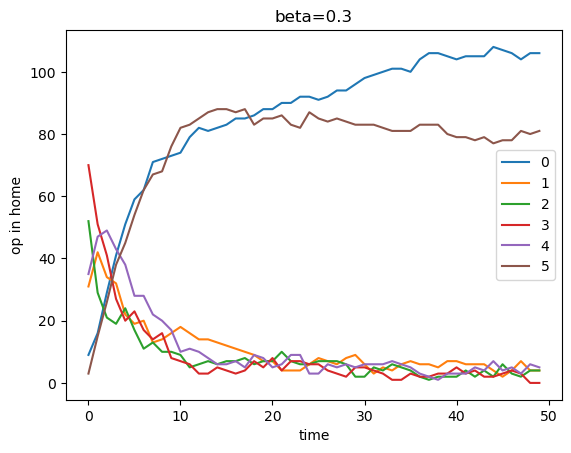

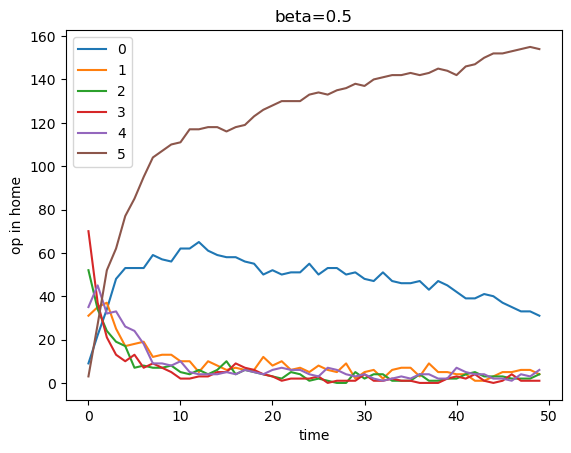

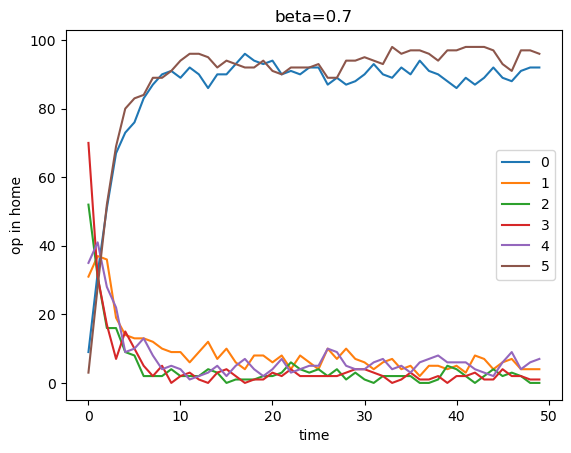

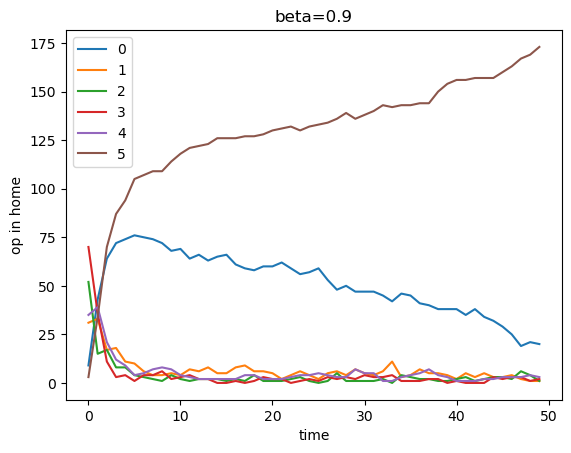

In [51]:
#egyszerű plot a vélemények összegéről
for beta_i, beta in enumerate(betas):
    plt.figure()
    plt.title(f'{beta=:.1f}')
    plt.plot(data[beta_i][0][1], label=[0,1,2,3,4,5])
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('op in home')
    plt.show()
    


In [6]:
len(H.edges)

2000

In [7]:
sum_A_by_edge = [np.sum(opinion[edge]==-1) for edge in H.edges]

In [4]:
name='d_regular'
args={'n':30, 'd':2,'edge size':5, 'distribution':'uniform'}


H = generate_hypergraph(name, args)
number_of_edges=len(H.edges)

In [5]:
H.edges

[[4, 19, 2, 21, 17],
 [7, 12, 13, 26, 8],
 [15, 5, 24, 0, 27],
 [18, 6, 22, 9, 11],
 [16, 20, 28, 14, 1],
 [23, 29, 10, 3, 25],
 [24, 17, 21, 16, 6],
 [14, 2, 9, 4, 29],
 [5, 27, 12, 0, 25],
 [1, 3, 28, 22, 11],
 [10, 13, 23, 20, 26],
 [18, 19, 7, 8, 15]]

In [26]:
import time

In [47]:
t1=time.time()

#hipergráf generálás

name='d_regular'
args={'n':1000, 'd':2,'edge size':5, 'distribution':'uniform'}


H = generate_hypergraph(name, args)
number_of_edges=len(H.edges)

### Egyszerű terjedés A=-1, B=1 vélemény fele-fele inicaializálással: ###

#inicializáljuk 
N=len(H.nodes) # csúcsok száma
opinion=-1*np.ones(N) # vélemény vektor
init_B=np.random.choice(H.nodes,int(N/2),replace=False) #random a fele B véleményre
opinion[init_B] = np.ones(len(init_B))

#beta a véleményváltoztatás paramétere
beta = 0.2

#q az élváltás paramétere
q = 0.9

#iterációk száma
iterations=100000

#list of logs
node_opinionslog=[]
sum_A_log=[np.sum(opinion==-1)]
sum_B_log=[np.sum(opinion==1)]
for i in range(iterations):
    act_node = np.random.choice(H.nodes,1)[0]
    try:
        diff_opinions = np.array([np.sum(opinion[edge]!=opinion[act_node]) for edge in H.edgelists[act_node]])
        
    except:
        print(act_node,H.edgelists[act_node])
        break
        
    edge_sizes = np.array([len(edge) for edge in H.edgelists])
    
    #terjedés : h élek m élek különböző vélemények aránya a háztartás és munkahely élekben: 
    #változás valószínűsége: beta * (h + 0.5 m) / 1.5
    p = np.random.random()
    h=diff_opinions[0]/edge_sizes[0]
    m= diff_opinions[1]/edge_sizes[1]
    if p < beta * np.sum(h + 0.5 * m)/1.5:
        opinion[act_node]=-1*opinion[act_node]
        
    elif m > 0.5 and np.random.random() < q * (m - 0.5):
        #print('edgelist',H.edgelists[act_node])
        sum_by_edge = np.array([np.sum(opinion[edge]==opinion[act_node]) for edge in H.edges])
        edge_to_move = np.random.choice(np.arange(int(number_of_edges/2)),1,p=sum_by_edge[int(number_of_edges/2):]/np.sum(sum_by_edge[int(number_of_edges/2):]))[0] + int(number_of_edges/2)
        H.edgelists[act_node][1].remove(act_node)
        H.edgelists[act_node].remove(H.edgelists[act_node][1])
        H.edges[edge_to_move].append(act_node)
        H.edgelists[act_node].append(H.edges[edge_to_move])
        #print('act node',act_node)
        #print('edge_to_move', H.edges[edge_to_move])
        #print('edgelist',H.edgelists[act_node])
        #print('edges',H.edges)
        
    sum_A_log.append(np.sum(opinion == -1))
    sum_B_log.append(np.sum(opinion == 1))
    
    
print('time:' , time.time()-t1)

time: 17.318156957626343


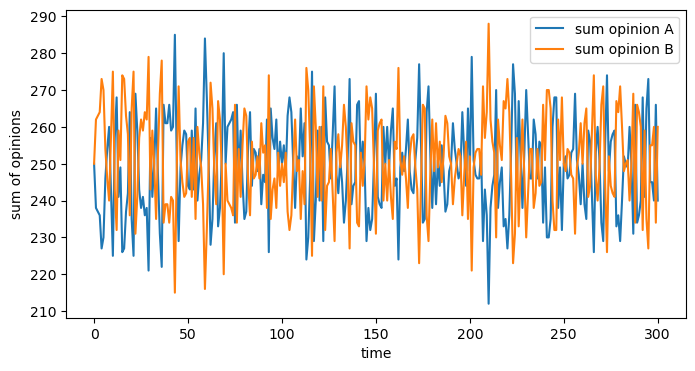

In [38]:
#egyszerű plot a vélemények összegéről

plt.figure(figsize=(8,4))
plt.plot(sum_A_log[::1000], label='sum opinion A')
plt.plot(sum_B_log[::1000], label='sum opinion B')
plt.xlabel('time')
plt.ylabel('sum of opinions')
plt.legend()
plt.show()

In [21]:
# distribution of workplace edge sizes
edge_sizes=[len(edge) for edge in H.edges[:int(number_of_edges/2)]]
z=np.histogram(edge_sizes, bins=np.arange(7))

In [22]:
z[0]

array([ 0,  0,  0,  0,  0, 20])

(array([11.,  0.,  0.,  0., 15.,  0.,  0.,  0., 27.,  0.,  0.,  0., 23.,
         0.,  0.,  0., 18.,  0.,  0.,  6.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

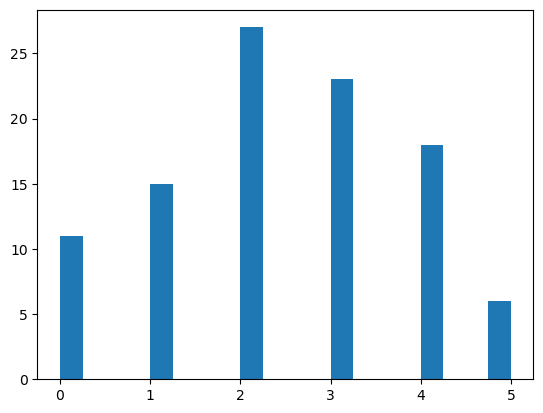

In [39]:
# distribution inside the edges
opidistr=[np.sum(opinion[edge]==-1) for edge in H.edges[:int(number_of_edges/2)]]

plt.hist(opidistr, bins=20)


(array([27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1., 51.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0., 18.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

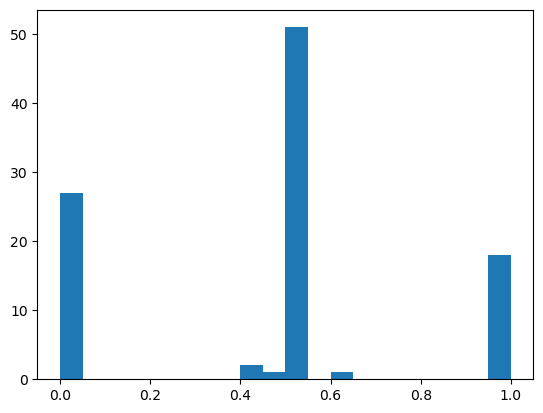

In [40]:
# distribution inside the edges
opidistr=[np.sum(opinion[edge]==-1)/len(edge) for edge in H.edges[int(number_of_edges/2):]]

plt.hist(opidistr, bins=20)


In [33]:
#q=1,beta=1

1

(array([93.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([ 2.  ,  5.05,  8.1 , 11.15, 14.2 , 17.25, 20.3 , 23.35, 26.4 ,
        29.45, 32.5 , 35.55, 38.6 , 41.65, 44.7 , 47.75, 50.8 , 53.85,
        56.9 , 59.95, 63.  ]),
 <BarContainer object of 20 artists>)

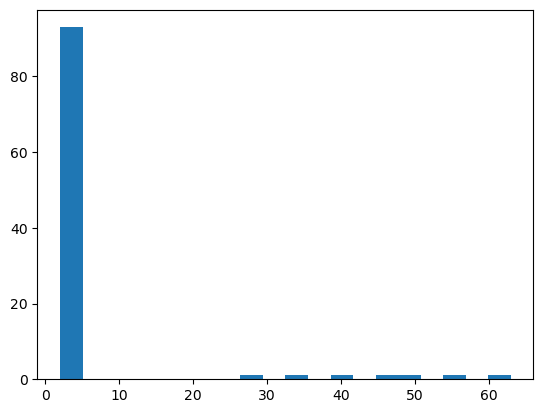

In [41]:
# distribution inside the edges
opidistr=[len(edge) for edge in H.edges[int(number_of_edges/2):]]

plt.hist(opidistr, bins=20)

In [34]:
beta

0.8

(array([ 4.,  0.,  0.,  0., 17.,  0.,  0.,  0., 21.,  0.,  0., 22.,  0.,
         0.,  0.,  0., 22.,  0.,  0., 14.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

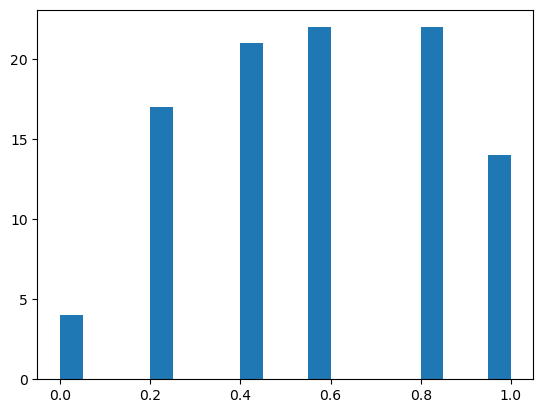

In [36]:
# distribution inside the edges
opidistr=[np.sum(opinion[edge]==-1)/len(edge) for edge in H.edges[:int(number_of_edges/2)]]

plt.hist(opidistr, bins=20)

(array([106.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  94.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

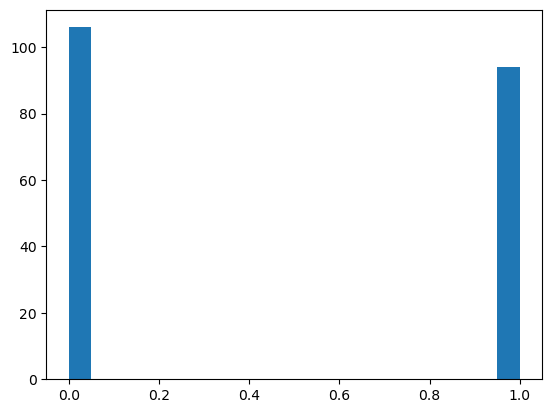

In [18]:
# distribution inside the edges
opidistr=[np.sum(opinion[edge]==-1)/len(edge) for edge in H.edges[:int(number_of_edges/2)]]

plt.hist(opidistr, bins=20)

(array([45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 54.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

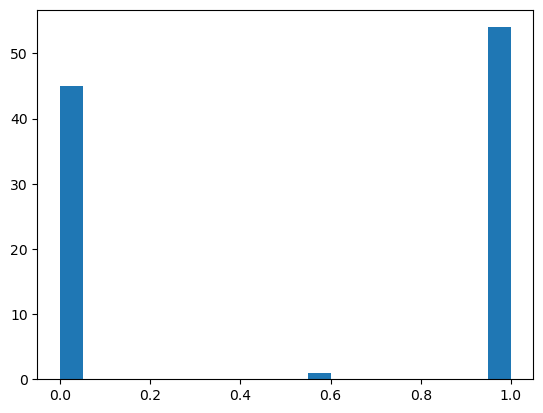

In [43]:
# distribution inside the edges
opidistr=[np.sum(opinion[edge]==-1)/len(edge) for edge in H.edges[:int(number_of_edges/2)]]

plt.hist(opidistr, bins=20)

(array([25., 19., 12., 10., 11.,  6.,  4.,  3.,  2.,  2.,  2.,  1.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  ]),
 <BarContainer object of 20 artists>)

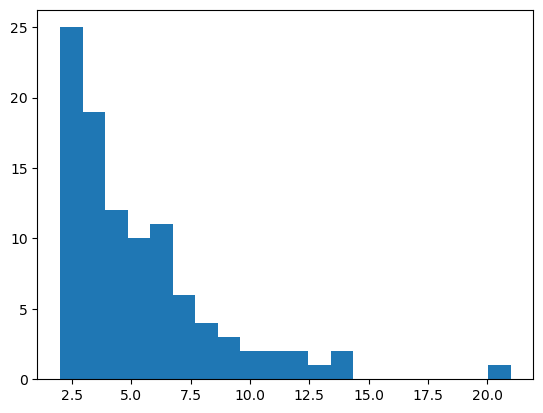

In [45]:
# distribution inside the edges
opidistr=[len(edge) for edge in H.edges[int(number_of_edges/2):]]

plt.hist(opidistr, bins=20)

In [4]:
from agent_country import run_parallel

In [20]:
np.arange(7)

array([0, 1, 2, 3, 4, 5, 6])

In [7]:
a = [np.arange(0.3,0.8,0.1), np.arange(0.3,0.8,0.1), np.arange(0.3,0.8,0.1) ]

In [12]:
list_to_save = [" ".join(map(str, np.round(act, 1))) for act in a]

In [13]:
list_to_save

['0.3 0.4 0.5 0.6 0.7', '0.3 0.4 0.5 0.6 0.7', '0.3 0.4 0.5 0.6 0.7']

In [17]:
len(data)

1200

In [24]:
data[3][1]

'binned_edge_sizes_wp'

In [53]:
from agent_country import run, run_parallel

In [61]:
graph_args={'name': 'd_regular', 'args': {'n':50, 'd':2,'edge size':5, 'distribution':'uniform'}}
d = run(graph_args, beta = 0.2, q=0.4, r1=1,r2=1,lambda_=0.5, endtime=50, move='majority',log_freq=10, seed=0, spread_type='het')

[5 5]
[3 4]
0.6 0.8 0.6666666666666666 1
[5 5]
[3 3]
0.6 0.6 0.6 1
[5 5]
[2 4]
0.4 0.8 0.5333333333333333 1
[5 5]
[4 3]
0.8 0.6 0.7333333333333334 1
[5 5]
[4 3]
0.8 0.6 0.7333333333333334 1
[5 5]
[2 4]
0.4 0.8 0.5333333333333333 1
[5 5]
[2 1]
0.4 0.2 0.3333333333333333 1
[5 5]
[3 2]
0.6 0.4 0.5333333333333333 1
[5 5]
[1 4]
0.2 0.8 0.4000000000000001 1
[5 5]
[4 4]
0.8 0.8 0.8000000000000002 1
[5 5]
[4 4]
0.8 0.8 0.8000000000000002 1
[5 5]
[2 3]
0.4 0.6 0.4666666666666666 1
[5 5]
[3 3]
0.6 0.6 0.6 1
[5 5]
[4 4]
0.8 0.8 0.8000000000000002 1
[5 5]
[3 1]
0.6 0.2 0.4666666666666666 1
[5 5]
[2 3]
0.4 0.6 0.4666666666666666 1
[5 5]
[1 4]
0.2 0.8 0.4000000000000001 1
[5 5]
[2 3]
0.4 0.6 0.4666666666666666 1
[5 5]
[3 2]
0.6 0.4 0.5333333333333333 1
[5 5]
[3 2]
0.6 0.4 0.5333333333333333 1
[5 5]
[2 3]
0.4 0.6 0.4666666666666666 1
[5 4]
[4 3]
0.8 0.75 0.7833333333333333 1
[5 5]
[1 4]
0.2 0.8 0.4000000000000001 1
[5 6]
[1 3]
0.2 0.5 0.3 1
[5 5]
[5 2]
1.0 0.4 0.7999999999999999 1
[5 5]
[4 2]
0.8 0.4

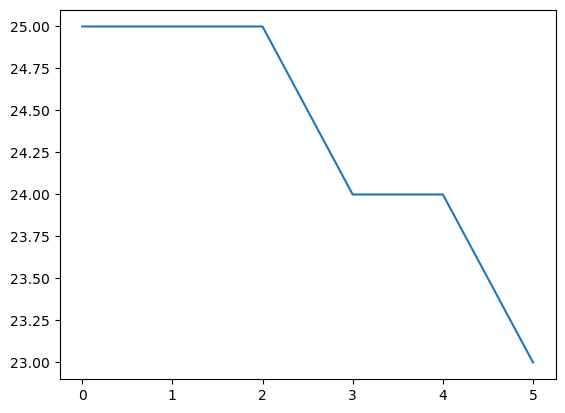

In [62]:
plt.plot(d[0])